# Project 8: CNN

## Instructions

### Description

In this project you will be learning about Convolutional Neural Networks (CNN) and messing with the parameters to see how they can change the output of the CNN. You will start with some questions about Tensorflow, the python package used for CNN! Good luck!

### Grading

For grading purposes, we will clear all outputs from all your cells and then run them all from the top.  Please test your notebook in the same fashion before turning it in.

### Submitting Your Solution

To submit your notebook, first clear all the cells (this won't matter too much this time, but for larger data sets in the future, it will make the file smaller).  Then use the File->Download As->Notebook to obtain the notebook file.  Finally, submit the notebook file on Canvas.


## 40 points

### Instructions
- The **"MNIST" data set** is composed of 28x28 pixel, black and white images of handwritten digits (0-9). It is commonly used to demonstrate the training and testing of CNNs.
- **We provide you with framework code** to build a CNN of roughly suitable size for the MNIST digit recognition task.


- **Your tasks**:
    1. Read the linked article and answer the questions under the "What is Tensorflow" section
    2. **Execute the train/test code** and observe the results of the gradient descent training.
    3. Complete all 4 modifications of the code, thee modification instructions are:
         - **Modify the model architecture in the following ways**, and repeat the training and testing. Each modification should be made relative to the original network. Do not keep "adding" each modification with each new model (which would lead to a final model having all the modifications below):
           - **Modification 1**: Remove the ReLU activation functions and the max-pooling layers, thereby making the entire network a linear function.
           - **Modification 2**: Increase the size of the model by a factor of 16, roughly.
           - **Modification 3**: Convert the large convolutional model to a large non-convolutional model, with roughly the same number of parameters.
           - **Modification 4**: Train the original baseline model with a larger training data set. 
     4. MAKE SURE THAT: along the way, **answer the questions in the Jupyter notebook cells**. You can just do this with comments within the cell, for example...
   - ```## Answer 1: The training loss increased when I did x, y, and z.```

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import time

np.random.seed(0)
tf.random.set_seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

# Part 1
## What is TensorFlow? (6 pts)

Before we get started with the rest of the project, let's talk about what tensorflow is. You are required to read this article https://www.guru99.com/what-is-tensorflow.html, and answer the following questions:

1. What are the three parts of the TensorFlow Architecture?
(1)Preprocessing the data;
(2)Build the model;
(3)Train and estimate the model
2. What is a Tensor and how does it represent data?
A tensor is a vector or matrix of n-dimensions that represents all types of data.All values in a tensor hold identical data type with a known (or partially known) shape. The shape of the data is the dimensionality of the matrix or array.
3. What is one advantage of the use of graphs in TensorFlow?
The portability of the graph allows to preserve the computations for immediate or later use. The graph can be saved to be executed in the future.

# Part 2
## Set TensorFlow verbosity level

In [12]:
verbose = 2 # 0==no output, 1=accuracy/loss output, 2=progress bar output

## Create helper function to plot results of our model training

In [13]:
def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

## Load the MNIST data

### You will not need to re-run or re-use (cut/paste) the three code cells below.

The full dataset has 60,000 training images and 10,000 test images.

To accelerate training on jupyterhub (with lots of users) we will only  
use a subset of the training set. This will also let us explore some of the  
hazards of training a neural net without a very large set of samples.

In [14]:
# Load data
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

# Use a subset of the full training and test sets for actual training and testing,
# to accelerate training, and demonstrate possible pitfalls of smaller training data sets.

n_train = 1000
images_train = images_train[0:n_train,:,:]
labels_train = labels_train[0:n_train]

n_test = 1000
images_test = images_test[0:n_test,:,:]
labels_test = labels_test[0:n_train]

## Let's graph a few of the MNIST digits, to confirm that they look as expected

Using plt.imshow(), graph the first sixteen numbers in the training images.

(1000, 28, 28)


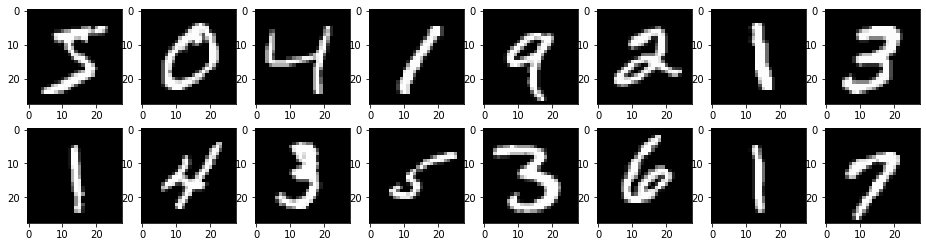

In [15]:
## You will not need to run this cell more than once, or cut/paste it elsewhere
plt.figure(figsize=(8*2, 2*2))

print(images_train.shape)
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(images_train[i,:,:], cmap = 'gray')

In [16]:
# Create TensorFlow Dataset objects to hold train and test data.
images_train = images_train/255 
images_train = np.expand_dims(images_train, axis=3) # TensorFlow expects a channel dimension
images_train = tf.cast(images_train, tf.float32)
labels_train = tf.cast(labels_train, tf.float32)
dataset_train = tf.data.Dataset.from_tensor_slices((images_train, labels_train))

images_test = images_test/255
images_test = np.expand_dims(images_test, axis=3) # TensorFlow expects a channel dimension
images_test = tf.cast(images_test, tf.float32)
labels_test = tf.cast(labels_test, tf.float32)
dataset_test = tf.data.Dataset.from_tensor_slices((images_test, labels_test))

batch_size = 50

dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(n_train)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

dataset_test = dataset_test.cache()
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.cache()
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

## Construct, compile, and train the baseline model. (4 pts)


The code will plot the loss and accuracy scores that were collected during training. Remember that training uses gradient descent, so the model parameters are slowly updated as the model gets a closer and closer fit to the data. TensorFlow records the scores after each "epoch"--the number of iterations at which all samples in the training set have been used once, in the gradient descent process.

We are now going to build teh model. In tensorflow, we build the model by first defining all the layers that the model is going to have, then we compile the model. Finally, we can train the model. We are going to define the model first. The rest is taken care of for you. 

We do this by calling `tf.keras.models.Sequential()` and inputting the list of layers, in order, as the parameter. Our baseline model is going to include two convalutional layers with pooling layers after each one, then we are going to have one dense layer with 64 neurons. It will then conclude with a dense layer of 10 that is our output layer. (Hint, you need to reduce the dimensionality before the data enters the neural network part of the model!)

The following are names of layers that may be useful: 

  `tf.keras.layers.Conv2D()`

  `tf.keras.layers.MaxPool2D()`

  `tf.keras.layers.Flatten()`

  `tf.keras.layers.Dense()`

For our model, we want to make sure that our convolutional layers have a kernel size of 3x3, 4 kernels, and use the 'relu' activation. Our pooling layers are going to have a 2x2 pooling same and `padding='same'`.   Don't foget to add the relu activation to the dense layer with 64 neurons. 

More information about the layers can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers)!


Epoch 1/30
20/20 - 1s - loss: 2.2670 - accuracy: 0.1300 - val_loss: 2.1572 - val_accuracy: 0.3190
Epoch 2/30
20/20 - 0s - loss: 1.9825 - accuracy: 0.5170 - val_loss: 1.8170 - val_accuracy: 0.5530
Epoch 3/30
20/20 - 0s - loss: 1.4628 - accuracy: 0.7280 - val_loss: 1.3054 - val_accuracy: 0.6520
Epoch 4/30
20/20 - 0s - loss: 0.9315 - accuracy: 0.7820 - val_loss: 0.9109 - val_accuracy: 0.7390
Epoch 5/30
20/20 - 0s - loss: 0.6359 - accuracy: 0.8300 - val_loss: 0.7529 - val_accuracy: 0.7510
Epoch 6/30
20/20 - 0s - loss: 0.5124 - accuracy: 0.8600 - val_loss: 0.6956 - val_accuracy: 0.7780
Epoch 7/30
20/20 - 0s - loss: 0.4504 - accuracy: 0.8760 - val_loss: 0.5850 - val_accuracy: 0.8080
Epoch 8/30
20/20 - 0s - loss: 0.3932 - accuracy: 0.8820 - val_loss: 0.5615 - val_accuracy: 0.8040
Epoch 9/30
20/20 - 0s - loss: 0.3685 - accuracy: 0.8980 - val_loss: 0.5257 - val_accuracy: 0.8140
Epoch 10/30
20/20 - 0s - loss: 0.3212 - accuracy: 0.9140 - val_loss: 0.4709 - val_accuracy: 0.8380
Epoch 11/30
20/20 -

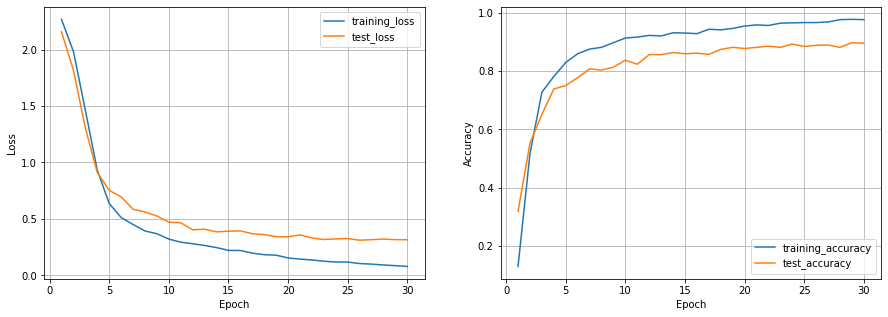

In [19]:
## This is the baseline model. 

##Your Code goe here
num_kernels = 4
dense_layer_neurons = 64
kernels_size = (3,3)
pooling_size = (2,2)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pooling_size, padding='same'),
    
    tf.keras.layers.Conv2D(num_kernels,kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pooling_size, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

## Part 2 Questions (6 pts)

### Using the baseline model, answer the questions below

In [15]:
##Assume one image is pushed through as the sole input, and asnwer with three dimensions.

##(Hint: The default stride for MaxPool2D is 2, and the default stride for Conv2D is 1!)

##Questions 1: What is the dimensionality of the input before it has gone through any layers?
##Question 2: What is its dimensionality after passing through the first convulational layer?
##Question 3: What is its dimensionality after passing through the first convulational layer and the first pooling layer?

##Answer 1: 
##  The dimensionality is (28, 28, 1)
##Answer 2: 
##   The dimensionality is (28, 28, 4)
##Answer 3:
## The dimensionality is (14, 14, 4)

## MODIFICATION 1 (6 pts)

### Copy code from cell above, that builds and trains the baseline model, and plots the results.
### Now alter the model as described below, and run the code.
Alter the model by removing the ReLU and max-pooling non-linear activations.  

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/30
20/20 - 0s - loss: 1.2052 - accuracy: 0.6390 - val_loss: 0.7833 - val_accuracy: 0.7550
Epoch 2/30
20/20 - 0s - loss: 0.4353 - accuracy: 0.8740 - val_loss: 0.5466 - val_accuracy: 0.8240
Epoch 3/30
20/20 - 0s - loss: 0.3044 - accuracy: 0.9160 - val_loss: 0.5234 - val_accuracy: 0.8480
Epoch 4/30
20/20 - 0s - loss: 0.2171 - accuracy: 0.9440 - val_loss: 0.5261 - val_accuracy: 0.8450
Epoch 5/30
20/20 - 0s - loss: 0.1689 - accuracy: 0.9580 - val_loss: 0.5139 - val_accuracy: 0.8460
Epoch 6/30
20/20 - 0s - loss: 0.1253 - accuracy: 0.9670 - val_loss: 0.5622 - val_accuracy: 0.8420
Epoch 7/30
20/20 - 0s - loss: 0.0883 - accuracy: 0.9830 - val_loss: 0.5814 - val_accuracy: 0.8320
Epoch 8/30
20/20 - 0s - loss: 0.0680 - accuracy: 0.9860 - val_loss: 0.6725 - val_accuracy: 0.8210
Epoch 9/30
20/20 - 0s - loss: 0.0516 - accuracy: 0.9910 - val_loss: 0.6858 - val_accuracy: 0.8230
Epoch 10/30
20/20 - 0s - loss: 0.0332 - accuracy: 0.9990 - val_loss: 0.6845 - val_accuracy: 0.8380
Epoch 11/30
20/20 -

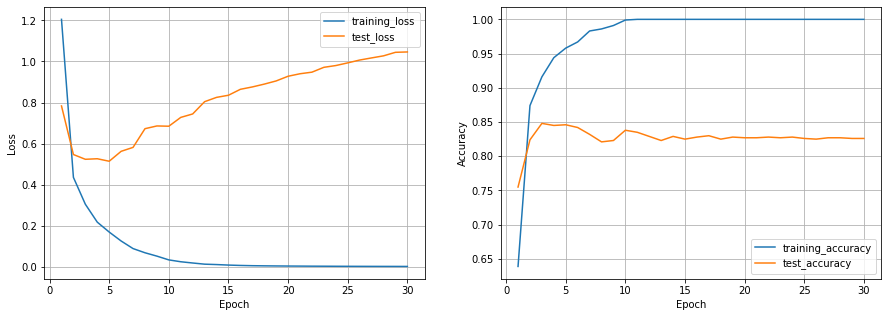

In [19]:
## MODIFICATION 1
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
%load_ext tensorboard
%tensorboard --logdir logs

## This is the baseline model. 

##Your Code goe here
num_kernels = 4
dense_layer_neurons = 64
kernels_size = (3,3)
pooling_size = (2,2)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size),
    
    tf.keras.layers.Conv2D(num_kernels,kernels_size),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(dense_layer_neurons),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

In [ ]:
## MODIFICATION 1
## QUESTION 1: During training, how did the loss (error) curves change from the baseline model to the linear (MOD 1)
##             model, for both the training and test sets? What does this imply regarding underfitting or overfitting?
## QUESTION 2: In general, did the ReLU and max-pooling non-linearities make for a better model or a worse model?

## Answer 1: The loss curve falls faster during the taining, but the loss curve increases after the epoch = 2 in the test. This imply regarding overfitting. 
##
## Answer 2:
## In general, the ReLU and max-pooling non-linearities make for a better model.

## MODIFICATION 2 (6 pts)

### Copy code from the baseline model, for building, training, and plotting results.
### Now alter the model as described below, and run the code.

Make the network much larger, by:
1. Increasing the number of kernels in the convolutional layers from 4 to 64 (16x).
2. Increasing the number neurons in the dense layer from 64 to 1024 (16x).

Epoch 1/30
20/20 - 1s - loss: 1.2579 - accuracy: 0.5920 - val_loss: 0.7187 - val_accuracy: 0.7900
Epoch 2/30
20/20 - 1s - loss: 0.3937 - accuracy: 0.8840 - val_loss: 0.3518 - val_accuracy: 0.8830
Epoch 3/30
20/20 - 1s - loss: 0.1971 - accuracy: 0.9530 - val_loss: 0.3229 - val_accuracy: 0.9000
Epoch 4/30
20/20 - 1s - loss: 0.1375 - accuracy: 0.9620 - val_loss: 0.2258 - val_accuracy: 0.9240
Epoch 5/30
20/20 - 1s - loss: 0.0875 - accuracy: 0.9730 - val_loss: 0.2226 - val_accuracy: 0.9320
Epoch 6/30
20/20 - 1s - loss: 0.0549 - accuracy: 0.9840 - val_loss: 0.2123 - val_accuracy: 0.9320
Epoch 7/30
20/20 - 1s - loss: 0.0258 - accuracy: 0.9940 - val_loss: 0.1712 - val_accuracy: 0.9450
Epoch 8/30
20/20 - 1s - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.1994 - val_accuracy: 0.9350
Epoch 9/30
20/20 - 1s - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.2150 - val_accuracy: 0.9340
Epoch 10/30
20/20 - 1s - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.1796 - val_accuracy: 0.9430
Epoch 11/30
20/20 -

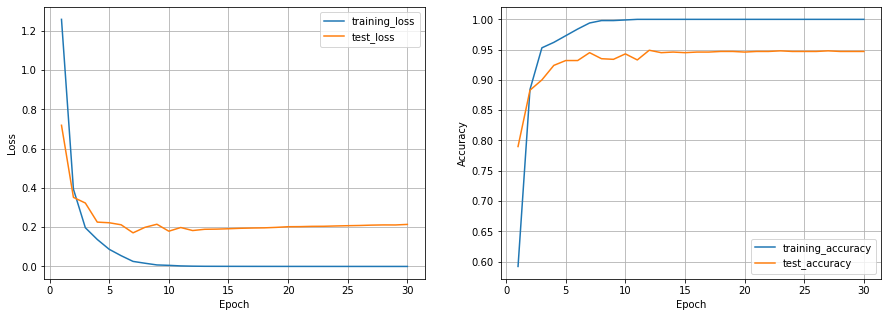

In [20]:
## MODIFICATION 2
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
## This is the baseline model. 

##Your Code goe here
num_kernels = 64
dense_layer_neurons = 1024
kernels_size = (3,3)
pooling_size = (2,2)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pooling_size, padding='same'),
    
    tf.keras.layers.Conv2D(num_kernels,kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pooling_size, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

In [ ]:
## MODIFICATION 2
## QUESTION 1: How did the performance of the larger model (MOD 2) compare to that of the baseline model?
## QUESTION 2: Based on the training curves, does the larger model show any **clear** signs of overfitting,
##             despite the large number of parameters?

## Answer 1:
## The perdormance of the large medel is better than the baseline model, with both higher accuracy and lower loss on both training and test sets.
## Answer 2:
## The larger model did not show any **clear** signs of overfitting.Because the loss value has no clear increase, and the accuracy has no clear decrease.

## MODIFICATION 3 (6 pts)

### Copy code from the baseline model, for building, training, and plotting results.
### Now alter the model as described below, and run the code.

**Relative to the MOD 2 model**, remove the convolutional and max-pooling layers, replacing them with a single, new, dense layer.

The two convolutional layers have 640 and 36,928 parameters, respectively, for a total of 37,586.
For an input of 28x28 = 784 pixels (features), a dense layer with 48 neurons will have roughly 784x48 = 37,632 parameters. Thus, do the following:
1. Remove the convolutional and max-pooling layers.
2. After the Flatten() layer, add a new Dense layer with 48 neurons and a ReLU activation function.
3. Keep the (now second) Dense layer of dense_layer_neurons==1024 neurons, and the final Dense layer of 10 neurons.

Epoch 1/30
20/20 - 0s - loss: 1.8175 - accuracy: 0.5290 - val_loss: 1.2511 - val_accuracy: 0.6650
Epoch 2/30
20/20 - 0s - loss: 0.7297 - accuracy: 0.8060 - val_loss: 0.6679 - val_accuracy: 0.7700
Epoch 3/30
20/20 - 0s - loss: 0.4123 - accuracy: 0.8840 - val_loss: 0.5607 - val_accuracy: 0.8230
Epoch 4/30
20/20 - 0s - loss: 0.2957 - accuracy: 0.9160 - val_loss: 0.5102 - val_accuracy: 0.8230
Epoch 5/30
20/20 - 0s - loss: 0.2224 - accuracy: 0.9440 - val_loss: 0.4897 - val_accuracy: 0.8420
Epoch 6/30
20/20 - 0s - loss: 0.1729 - accuracy: 0.9560 - val_loss: 0.4796 - val_accuracy: 0.8520
Epoch 7/30
20/20 - 0s - loss: 0.1229 - accuracy: 0.9740 - val_loss: 0.5005 - val_accuracy: 0.8430
Epoch 8/30
20/20 - 0s - loss: 0.1046 - accuracy: 0.9730 - val_loss: 0.4914 - val_accuracy: 0.8420
Epoch 9/30
20/20 - 0s - loss: 0.0750 - accuracy: 0.9850 - val_loss: 0.5018 - val_accuracy: 0.8540
Epoch 10/30
20/20 - 0s - loss: 0.0565 - accuracy: 0.9930 - val_loss: 0.5011 - val_accuracy: 0.8490
Epoch 11/30
20/20 -

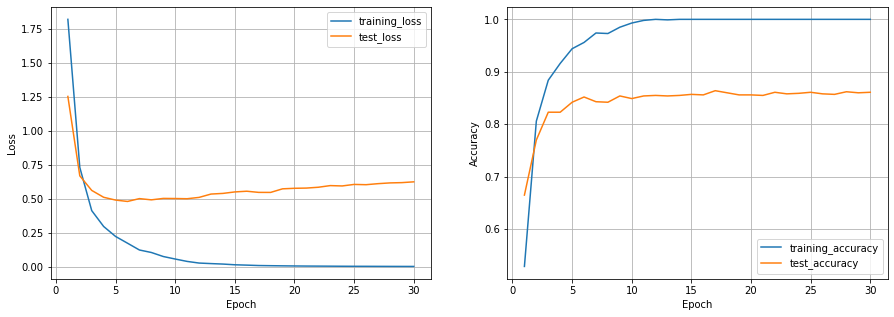

In [20]:
## MODIFICATION 3
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
## This is the baseline model. 

##Your Code goe here
num_kernels = 4
dense_layer_neurons = 1024
kernels_size = (3,3)
pooling_size = (2,2)

model = tf.keras.models.Sequential([ 
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(48, activation='relu'),
    
    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

In [ ]:
## MODIFICATION 3
## QUESTION 1: How did the performance of the large non-convolutional model (MOD 3) compare to that of the
##             large convolutional model (MOD 2)?
## QUESTION 2: Speculate on why the convolutional model performs better or worse than the non-convolutional model.
##             There is a "right" answer, but we're just looking for your opinion/guess. No penalty for error.

## Answer 1:
## The performance of the large non-convolutional model (MOD 3) is worse than the large convolutional model (MOD 2).
## Answer 2:
## The convolutional layers are the foundation of CNN, as they contain the learned kernels (weights), which extract features that distinguish different images from one another—this is what we want for classification

## MODIFICATION 4 (6 pts)

## This model/data with take longer to train the the previous ones--upwards of several minutes.

### For the modification, we don't modify the model, we modify the size of the data sets. The two cells below create training and testing sets with 10,000 samples each, whereas our previous models used only 1,000 samples each.

### Copy code from the baseline model, for building, training, and plotting results.
- Place the copied code after the two cells below.  
- Run all the cells below to get the new data sets, and train the baseline model on that data.

In [ ]:
# Load data
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

# Use a subset of the full training and test sets for actual training and testing,
# to accelerate training, and demonstrate possible pitfalls of smaller training data sets.

n_train = 10000
images_train = images_train[0:n_train,:,:]
labels_train = labels_train[0:n_train]

n_test = 10000
images_test = images_test[0:n_test,:,:]
labels_test = labels_test[0:n_train]

In [ ]:
# Create TensorFlow Dataset objects to hold train and test data.
images_train = images_train/255
images_train = np.expand_dims(images_train, axis=3) # TensorFlow expects a channel dimension
images_train = tf.cast(images_train, tf.float32)
labels_train = tf.cast(labels_train, tf.float32)
dataset_train = tf.data.Dataset.from_tensor_slices((images_train, labels_train))

images_test = images_test/255
images_test = np.expand_dims(images_test, axis=3) # TensorFlow expects a channel dimension
images_test = tf.cast(images_test, tf.float32)
labels_test = tf.cast(labels_test, tf.float32)
dataset_test = tf.data.Dataset.from_tensor_slices((images_test, labels_test))

dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(n_train)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(tf.data.experimental.AUTOTUNE)

dataset_test = dataset_test.cache()
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.cache()
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

Epoch 1/30
20/20 - 0s - loss: 2.2596 - accuracy: 0.1680 - val_loss: 2.1883 - val_accuracy: 0.3330
Epoch 2/30
20/20 - 0s - loss: 2.0248 - accuracy: 0.4810 - val_loss: 1.8633 - val_accuracy: 0.5220
Epoch 3/30
20/20 - 0s - loss: 1.4771 - accuracy: 0.6810 - val_loss: 1.2320 - val_accuracy: 0.6990
Epoch 4/30
20/20 - 0s - loss: 0.8575 - accuracy: 0.8060 - val_loss: 0.7922 - val_accuracy: 0.7730
Epoch 5/30
20/20 - 0s - loss: 0.5582 - accuracy: 0.8470 - val_loss: 0.6509 - val_accuracy: 0.8020
Epoch 6/30
20/20 - 0s - loss: 0.4487 - accuracy: 0.8700 - val_loss: 0.5691 - val_accuracy: 0.8210
Epoch 7/30
20/20 - 0s - loss: 0.3912 - accuracy: 0.8840 - val_loss: 0.5025 - val_accuracy: 0.8340
Epoch 8/30
20/20 - 0s - loss: 0.3504 - accuracy: 0.9010 - val_loss: 0.4447 - val_accuracy: 0.8580
Epoch 9/30
20/20 - 0s - loss: 0.3155 - accuracy: 0.9130 - val_loss: 0.4251 - val_accuracy: 0.8710
Epoch 10/30
20/20 - 0s - loss: 0.2878 - accuracy: 0.9210 - val_loss: 0.3977 - val_accuracy: 0.8780
Epoch 11/30
20/20 -

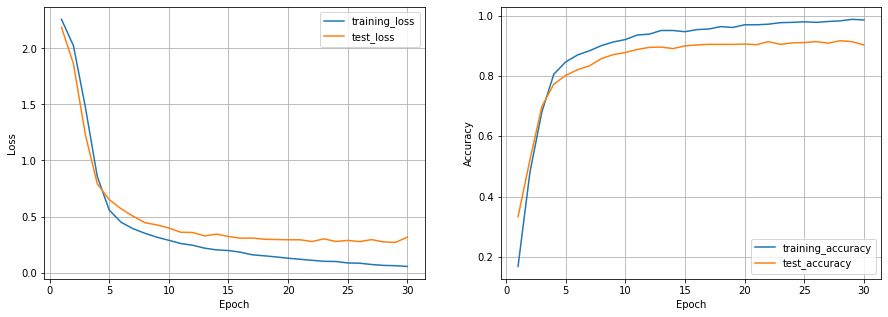

In [22]:
## MODIFICATION 4
## BELOW, PUT YOUR MODEL CONSTRUCTION, COMPILATION, AND FITTING CODE
## This is the baseline model. 

##Your Code goe here
num_kernels = 4
dense_layer_neurons = 64
kernels_size = (3,3)
pooling_size = (2,2)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pooling_size, padding='same'),
    
    tf.keras.layers.Conv2D(num_kernels,kernels_size, activation='relu'),
    tf.keras.layers.MaxPool2D(pooling_size, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(dense_layer_neurons, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Do not change any arguments in the call to model.compile()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),    
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Do not change any arguments in the call to model.fit()
epochs = 30
t = time.time()
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_test,
                    verbose=verbose)
print('Training duration: %f seconds.' % (time.time() - t))

# Plot results
plot_results(history)

In [ ]:
## MODIFICATION 4
## QUESTION 1: How did the performance of the baseline model trained on the larger data set (MOD 4) compare
##             to that trained on the smaller data set?
## QUESTION 2: This is just guess on your part... how much better do you think results might be if you trained
##             the model on all 60,000 training samples (rather than 1000 or 10,000)?

## Answer 1:
##  The performance of the baseline model trained on the larger data is liitle better than the smaller data set .
## Answer 2:
## I think it will do a little better if trained the model on all 60000 training samples.Because With more data, the model would have a greater variety of examples to learn.

### Questionnaire
1) How long did you spend on this assignment?
<br><br>2 hours
2) What did you like about it? What did you not like about it?
<br><br>Yes 
3) Did you find any errors or is there anything you would like changed?
<br><br>No error.